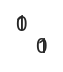

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.multimodal_metrics import BSSVAELoss
from src.utils import get_class_initcode_keys
from src.multimodal_models import BSSVAE
from src.multimodal_train_eval import predict_multimodal, multimodal_train_eval_loops, train_multimodal_step, eval_multimodal_step
from src.multimodal_datasets import MultimodalPepTCRDataset, MultimodalCLFLatentDataset
from src.datasets import TwoStageTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180



def get_model(folder, **kwargs):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, **kwargs)
    return model
    

In [4]:
from src.data_processing import PEP_MAP, PEP_MAP2

df = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')

# quick annealing checks

In [113]:

class AbstractParent():
    def __init__(self, arg_a):
        self.arg_a = arg_a
        self.max_len_tcr = 1

    def slice_x(self, x):
        print(x)
        print(self.max_len_tcr)

class ChildClass(AbstractParent):
    def __init__(self, max_len_tcr):
        super(ChildClass, self).__init__(arg_a='nothing')
        self.max_len_tcr = max_len_tcr

instance = ChildClass(max_len_tcr=12)
instance.slice_x(x='test')


test
12


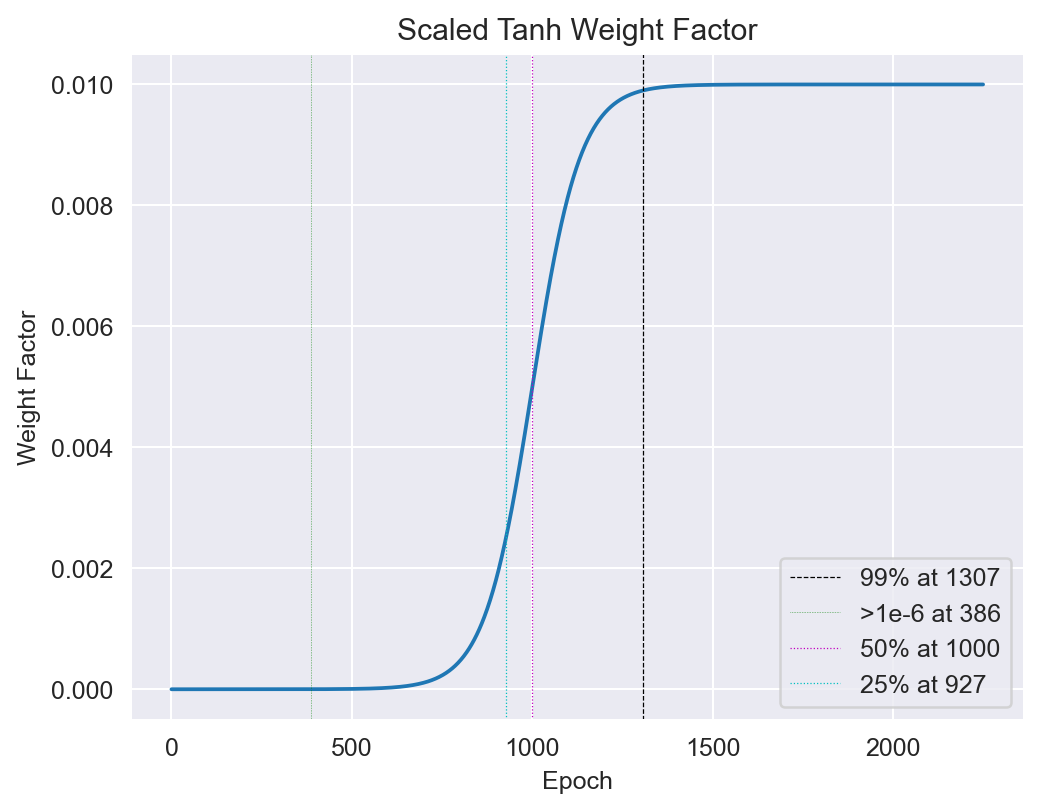

In [81]:
from src.utils import plot_tanh_annealing

plot_tanh_annealing(15000, 0.01, 0.0075, 1500)

In [83]:
n_epochs = 1500
for e in range(1, n_epochs+1):
    if (n_epochs >= 10 and e % math.ceil(0.1 * n_epochs) == 0) or e == 1 or e == n_epochs:
        print(e)


1
150
300
450
600
750
900
1050
1200
1350
1500


# BSSVAE with paired data

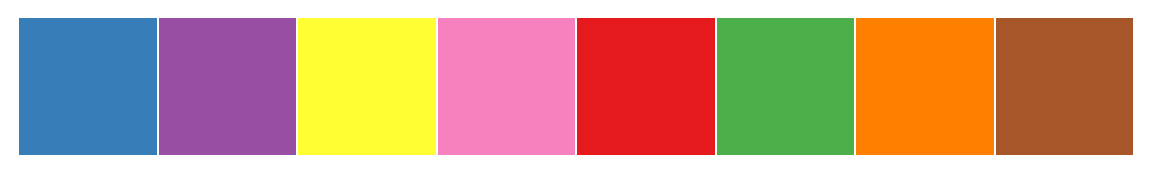

In [124]:
sns.palplot(get_palette('Set1', 8))

In [128]:
a = 1

c = 5
for b in range(10):
    print(b, a < b <= c)

0 False
1 False
2 True
3 True
4 True
5 True
6 False
7 False
8 False
9 False


tensor([0.0000e+00, 2.3779e-07, 2.4260e-07,  ..., 2.5000e-03, 2.5000e-03,
        2.5000e-03])


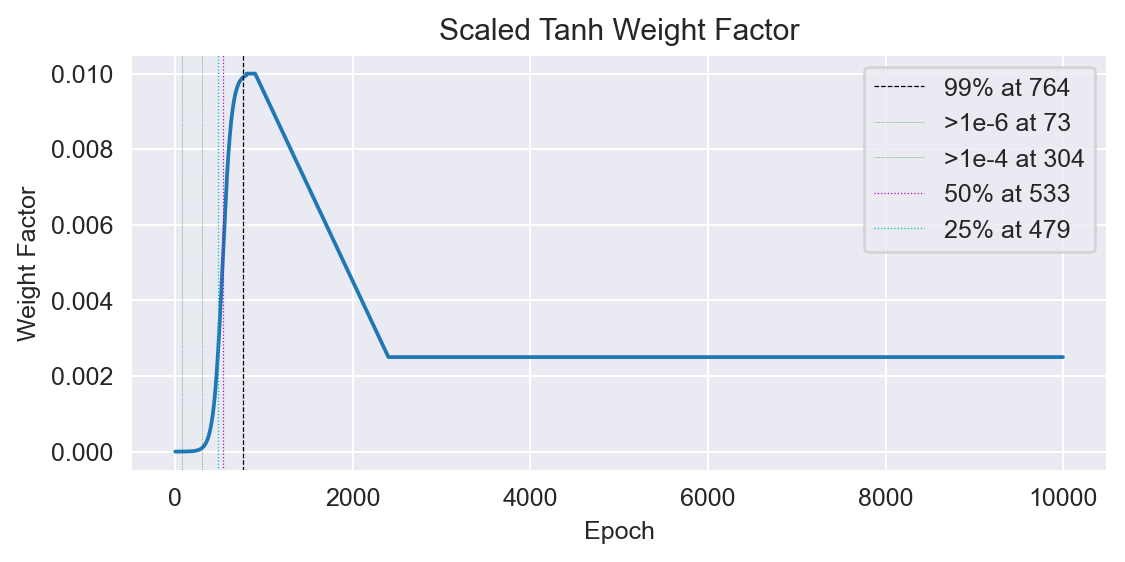

In [204]:
from src.multimodal_metrics import JMVAELoss, BSSVAELoss
from src.utils import plot_criterion_annealing
crit = BSSVAELoss(weight_kld_n = 1e-2, kld_warm_up = 800, kld_tanh_scale=0.01, flat_phase=100, kld_decrease=5e-4)
y = plot_criterion_annealing(10000, crit, 1)

In [153]:
base_weight = crit.base_weight_kld_n
p50 = torch.where((y < 0.5025 * base_weight) & (y > 0.4975 * base_weight))[0]
p50

tensor([466, 467])

# Re-loading models

In [205]:
multimodal_df = pd.read_csv('../data/multimodal/240314_multimodal_NO_HUMAN_tcr_pep.csv')

In [206]:
preds = pd.read_csv('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/valid_predictions_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.csv')

In [208]:
cols=[x for x in preds.columns if not x.startswith('z_')]
preds[cols]

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,partition,input_type,db,seq_true,seq_recon,seq_acc,fold
0,XXXXXXXXX,TSGFNG,NVLDGL,AAADSNYQLI,MRHNA,SNTAGT,ASSRQGGTDTQY,NaN,NaN,NaN,0,tcr,immrep_negs,TSGFNGXNVLDGLXXAAADSNYQLIXXXXXXXXXXXXMRHNAXSNT...,SSGYNGXTMTNGGXXAVTNSNHKLMXXXXXXXXXXXXTSHNTXTTN...,0.377778,0
1,XXXXXXXXX,NSMFDY,ISSIKDK,AAAEFDAGNMLT,LGHDT,YNNKEL,ASSQETSGSLTDTQY,NaN,NaN,NaN,0,tcr,immrep_negs,NSMFDYXISSIKDKXAAAEFDAGNMLTXXXXXXXXXXLGHDTXYNN...,SSATSGXITSNSNPXAASTASSSSKLCXXXXXXXXXXTGHETXYTN...,0.313726,0
2,XXXXXXXXX,SSVPPY,YTSAATLV,AAAGGSYIPT,MNHEY,SVGAGI,ASSLATNEKLF,NaN,NaN,NaN,0,tcr,immrep_negs,SSVPPYXYTSAATLVAAAGGSYIPTXXXXXXXXXXXXMNHEYXSVG...,TSATNWXMTSSNEPXAMTSSSNKLVXXXXXXXXXXXXTNHNTXTTN...,0.260870,0
3,XXXXXXXXX,DSASNY,IRSNVGE,AAAKSYNTDKLI,SGHDY,FNNNVP,ASSYRQGAETQY,NaN,NaN,NaN,0,tcr,immrep_negs,DSASNYXIRSNVGEXAAAKSYNTDKLIXXXXXXXXXXSGHDYXFNN...,SSATSGXITSSSDGXAASAASSSNKLVXXXXXXXXXXTNHETXYTN...,0.312500,0
4,XXXXXXXXX,SVFSS,VVTGGEV,AAANQAGTALI,LGHDT,YNNKEL,ASSLAGGPYEQY,NaN,NaN,NaN,0,tcr,immrep_negs,SVFSSXXVVTGGEVXAAANQAGTALIXXXXXXXXXXXLGHDTXYNN...,NSATSGXIMSNAEPXAASASSSNKLTXXXXXXXXXXXTNHETXYTN...,0.326087,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7727,AVFDRKSDAK,NSASQS,VYSSG,VVNAGGGADGLT,MNHEY,SVGAGI,ASSYPGQPQH,HLA-A*11:01,1.0,NaN,0,tcr_pep,nettcr,NSASQSXVYSSGXXXVVNAGGGADGLTXXXXXXXXXXMNHEYXSVG...,NSATQGXVYSNGGXXAVSAASSSSKLVXXXXXXXXXXTNHSTXTHN...,0.523102,0
7728,AVFDRKSDAK,VSGLRG,LYSAGEE,AVHTDNDYKLS,MGHRA,YSYEKL,ASSQARGGYEQY,HLA-A*11:01,1.0,NaN,0,tcr_pep,nettcr,VSGLRGXLYSAGEEXAVHTDNDYKLSXXXXXXXXXXXMGHRAXYSY...,SSATSGXIYSNGEGXAATSSSSNKLTXXXXXXXXXXXTNHETXTTN...,0.550013,0
7729,LLWNGPMAV,NSASQS,VYSSG,VVFNFNKFY,KGHSH,LQKENI,ASSPDGGHSTDTQY,HLA-A*02:01,1.0,NaN,0,tcr_pep,nettcr,NSASQSXVYSSGXXXVVFNFNKFYXXXXXXXXXXXXXKGHSHXLQK...,NTATQGXVYSNGGXXAVSSSNKLLXXXXXXXXXXXXXTNHSTXATN...,0.438954,0
7730,RAKFKQLL,NSASDY,IRSNMDK,AENEVGSQGNLI,SGHTA,FQGTGA,ASSFYAGSTNEQF,HLA-B*08:01,1.0,NaN,0,tcr_pep,nettcr,NSASDYXIRSNMDKXAENEVGSQGNLIXXXXXXXXXXSGHTAXFQG...,NSATNWXITSNADPXAASSASASNKLVXXXXXXXXXXTGHNTXYHN...,1.156783,0


In [227]:
from src.metrics import get_acc_list_string
preds['seq_acc'] = get_acc_list_string(preds['seq_true'], preds['seq_recon'])

In [228]:
preds.groupby('input_type')['seq_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
input_type,,,,,,,,
pep,2750.0,0.054416,0.075780,0.000000,0.000000,0.000000,0.111111,0.500000
tcr,3021.0,0.302699,0.074343,0.046512,0.254545,0.300000,0.348837,0.585366
tcr_pep,1961.0,0.282336,0.081287,0.087719,0.228070,0.271186,0.327273,0.618182


In [111]:
# 3rd test can load best
# redo 1st test can load 2250

first_model = get_model('../output/BSSVAE_worked/BSSVAE_FirstTest_200nh_100nl_15kepochs_250wu_KFold_0_240318_1645_07Gc9A/', verbose=True, map_location='cpu')

third_model = get_model('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/', verbose=True, map_location='cpu')
third_model_last = load_model_full('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/epoch_13500_interval_checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.pt',
                                   '../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c_JSON_kwargs.json',
                                   map_location='cpu')

Reloading best model:
Best epoch: 994
Best val loss: 0.08882168347223993
total: 0.08882168347223993
recon_marg: 0.02913100861700623
recon_joint: 0.023316913937379485
kld_marg: 0.0008898978936070389
kld_joint: 0.03548386655007012
tcr_marg_seq_accuracy: 0.29168784618377686
tcr_joint_seq_accuracy: 0.31561216711997986
pep_joint_seq_accuracy: 0.2850262224674225
pep_marg_seq_accuracy: 0.0527159683406353
mean_seq_accuracy: 0.23626055102795362
Reloading best model:
Best epoch: 2360
Best val loss: 0.09844853986227531
total: 0.09844853986227531
recon_marg: 0.029187592968899397
recon_joint: 0.030139345347060652
kld_marg: 0.0010232108396756776
kld_joint: 0.03809838730239674
tcr_marg_seq_accuracy: 0.2907351553440094
tcr_joint_seq_accuracy: 0.3056580126285553
pep_joint_seq_accuracy: 0.16265100240707397
pep_marg_seq_accuracy: 0.05322333797812462
mean_seq_accuracy: 0.20306687708944082
Reloading best model:
epoch: 13500
total: 0.4343040112267338
recon_marg: 0.028617679920809297
recon_joint: 0.020017263

In [241]:
nn.Identity??

Init signature: nn.Identity(*args: Any, **kwargs: Any) -> None
Source:        
class Identity(Module):
    r"""A placeholder identity operator that is argument-insensitive.

    Args:
        args: any argument (unused)
        kwargs: any keyword argument (unused)

    Shape:
        - Input: :math:`(*)`, where :math:`*` means any number of dimensions.
        - Output: :math:`(*)`, same shape as the input.

    Examples::

        >>> m = nn.Identity(54, unused_argument1=0.1, unused_argument2=False)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 20])

    """
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__()

    def forward(self, input: Tensor) -> Tensor:
        return input
File:           ~/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/torch/nn/modules/linear.py
Type:           type
Subclasses:     

In [248]:
test = [nn.Linear(100, 50), nn.LeakyReLU(), nn.BatchNorm1d(50),
        nn.Linear(50, 20), nn.LeakyReLU(), nn.BatchNorm1d(20)]
test.extend([nn.Linear(20, 10), nn.LeakyReLU(), nn.BatchNorm1d(10)])
test2 = [nn.Linear(100, 50), nn.LeakyReLU(), nn.Identity(50),
        nn.Linear(50, 20), nn.LeakyReLU(), nn.Identity(20)]
m = nn.Sequential(*test)
m2 = nn.Sequential(*test2)
x = torch.rand((100,100))

m(x)

tensor([[ 2.3526e-01, -2.9895e-01, -4.7957e-01, -4.6173e-01, -1.7089e-01,
         -2.8655e-01, -7.5871e-01, -3.1143e-01, -1.8083e-01,  4.8768e-01],
        [-6.0486e-01,  9.0394e-02, -7.4524e-01,  1.7329e+00, -5.8739e-01,
         -6.5449e-01, -6.1739e-01,  5.8146e-01, -6.7050e-01,  1.0021e+00],
        [-5.9844e-01, -7.4348e-01,  1.1644e+00, -4.7539e-01, -5.9805e-01,
         -5.3622e-01,  1.2740e-01, -8.6661e-01, -2.0065e-01, -1.1648e-01],
        [-4.6469e-02, -1.7896e-01, -7.6181e-01, -4.6614e-01, -6.0121e-01,
         -6.5935e-01, -7.6692e-01, -8.5411e-01, -6.7428e-01, -6.8079e-01],
        [ 4.9365e-01,  2.2271e+00,  1.9602e-01, -2.8226e-01,  2.5921e+00,
          1.9314e+00, -7.5687e-01, -8.6291e-01,  2.2532e+00,  2.0262e+00],
        [ 1.0160e+00,  2.0001e+00,  2.4067e+00, -4.7975e-01,  2.8203e+00,
         -3.0646e-01, -8.1242e-01,  8.3680e-01,  3.6275e+00, -6.6315e-01],
        [ 7.9421e-01,  1.8090e+00, -7.5387e-01, -4.5517e-01, -5.9512e-01,
         -6.6357e-01, -7.6702e-0

In [239]:
zz=torch.load('../output/2403XX_multimodal/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.pt',
           map_location='cpu')
zz['best']

{'Best epoch': 2360,
 'total': 0.09844853986227531,
 'recon_marg': 0.029187592968899397,
 'recon_joint': 0.030139345347060652,
 'kld_marg': 0.0010232108396756776,
 'kld_joint': 0.03809838730239674,
 'tcr_marg_seq_accuracy': 0.2907351553440094,
 'tcr_joint_seq_accuracy': 0.3056580126285553,
 'pep_joint_seq_accuracy': 0.16265100240707397,
 'pep_marg_seq_accuracy': 0.05322333797812462,
 'mean_seq_accuracy': 0.20306687708944082}

In [254]:
multimodal_df.query('peptide=="GILGFVFTL"').groupby(['A3', 'B3']).agg(count=('allele','count')).sort_values('count', ascending=False)

,,count
A3,B3,
AAAETSYDKVI,ATTYGDRRNTEAF,1
AVHLIWEGGGATNKLI,ATSDFTDSGANVLT,1
AVGGSQGNLI,ASMVGQGTGELF,1
AVGGNNNDMR,SARDYLNSYEQY,1
AVGGGGGSQGNLI,ASSSRSGTEQF,1
...,...,...
AGHGTASKLT,ASSGRSTDTQY,1
AGGYGGSQGNLI,ASSIRSVAEA,1
AGGRQTGANNLF,ASSYLEGSETQETQY,1


In [276]:
abdf = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv')
abdf['input_type'] = abdf['input_type'].apply(lambda x: {'beta':'pep', 'alpha':'tcr', 'paired':'tcr_pep'}[x])
abdf.query('binder==1').to_csv('../data/multimodal/240321_nettcr2-2_alpha_beta_fakemultimodal_bindersonly.csv', index=False)

[autoreload of src.datasets failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/riwa/Documents/code/tclustr/src/datasets.py", line 45

In [273]:
known_primes = [2,3]

def is_prime(n):
    if n <= 1:
        return False
    elif n <= 3:
        return True
    elif n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

import time
n=10000000

start = time.perf_counter()
[x for x in range(n) if is_prime(x)]
end = time.perf_counter()
end-start

20.506675291981082

In [270]:
def generate_primes_recursive(limit, primes=None):
    if primes is None:
        primes = []

    # Base case: if the limit is less than 2, return an empty list
    if limit < 2:
        return []

    # Base case: if there are no known primes yet, initialize primes with 2
    if not primes:
        primes.append(2)

    # Calculate the next potential prime number
    next_number = primes[-1] + 1

    # Check if the next number is prime by dividing it by all known primes
    for prime in primes:
        if next_number % prime == 0:
            # If the next number is divisible by any known prime, it's not prime
            break
    else:
        # If the loop completes without finding a divisor, the next number is prime
        primes.append(next_number)

    # If we haven't reached the limit yet, recursively call the function
    if next_number < limit:
        generate_primes_recursive(limit, primes)

    return primes

# Example usage:
limit = 10000
prime_list = generate_primes_recursive(limit, primes=[2,3])
print(prime_list)


RecursionError: maximum recursion depth exceeded

In [265]:
pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv').query('binder==1')

,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type
8,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1,1,VDJdb,TTDPSFLGRY,VDJdb_69875,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,paired
12,KRWIILGLNK,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,MNHNY,SVGAGI,ASSSSPGTSGNQPQH,HLA-B*27:05,2,1,VDJdb,KRWIILGLNK,VDJdb_954,21135165,HIV-1,beta
18,TVATSRTLSYYK,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,LNHDA,SQIVND,ASSTSRGGTEAF,NaN,1,1,IEDB,TVATSRTLSYYK,IEDB_123556,32793919,SARS-CoV1,beta
21,SMWSFNPETNIL,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SGHNT,YYREEE,ASSEGGMAYGYT,NaN,1,1,IEDB,SMWSFNPETNIL,IEDB_69947,32793919,SARS-CoV1,beta
34,RLQSLQTYV,TSENNYY,QEAYKQQN,AFDPLYNDMR,XXXXXX,XXXXXXX,XXXXXXXXXXXXXXXXXXXXXXX,HLA-A*02:01,3,1,VDJdb,RLQSLQTYV,VDJdb_4716,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417075,FLNGSCGSV,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,WNHNN,SYGVQD,ASSPTDGGADTQY,NaN,2,1,IEDB,FLNGSCGSV,IEDB_107654,32793919,SARS-CoV2,beta
417080,CMTSCCSCLK,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,WSHSY,SAAADI,AIRQDGAEY,NaN,3,1,IEDB,CMTSCCSCLK,IEDB_58798,32793919,SARS coronavirus Tor2 (Severe acute respirator...,beta
417081,FPRPWLHGL,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SQVTM,ANQGSEA,SVEDSLVNEQF,HLA-B*42:01,1,1,VDJdb,FPRPWLHGL,VDJdb_68648,25911754,HIV-1,beta
417084,VAANIVLTV,TSINN,IRSNERE,AVTGANNLF,LNHDA,SQIVND,ASSIEGPTGELF,HLA-A*02:01,0,1,VDJdb,VAANIVLTV,VDJdb_24025,29429978,HomoSapiens,paired


In [263]:
multimodal_df.query('B3=="ASSFSGNTGELF"').groupby(['partition','peptide']).count()

A1  A2  A3  B1  B2  B3  allele  binder  target  \
partition peptide                                                     
0         GILGFVFTL   3   3   3   3   3   3       3       3       0   
          RAKFKQLL   18  18  18  18  18  18      18      18       0   
1         GILGFVFTL   1   1   1   1   1   1       1       1       0   
          IVTDFSVIK   2   2   2   2   2   2       2       2       0   
          RAKFKQLL   14  14  14  14  14  14      14      14       0   
          YLLEMLWRL   1   1   1   1   1   1       1       1       0   
2         GILGFVFTL   1   1   1   1   1   1       1       1       0   
          RAKFKQLL   15  15  15  15  15  15      15      15       0   
3         RAKFKQLL   22  22  22  22  22  22      22      22       0   
4         GILGFVFTL   4   4   4   4   4   4       4       4       0   
          RAKFKQLL   21  21  21  21  21  21      21      21       0   

                     input_type  db  
partition peptide                    
0         GILGFVFTL           3   3  
          RAKFKQLL           18  18  
1         GILGFVFTL           1   1  
          IVTDFSVIK           2   2  
          RAKFKQLL           14  14  
          YLLEMLWRL           1   1  
2         GILGFVFTL           1   1  
          RAKFKQLL           15  15  
3         RAKFKQLL           22  22  
4         GILGFVFTL           4   4  
          RAKFKQLL           21  21

In [261]:
multimodal_df.query('B3=="ASSFSGNTGELF"').groupby('peptide').first()

,A1,A2,A3,B1,B2,B3,allele,binder,target,partition,input_type,db
peptide,,,,,,,,,,,,
GILGFVFTL,VSGNPY,YITGDNLV,AVAKDLQNSGGGADGLT,SGHNS,FNNNVP,ASSFSGNTGELF,HLA-A*02:01,1.0,NaN,1,tcr_pep,nettcr
IVTDFSVIK,SIFNT,LYKAGEL,AGHTGNQFY,SGHNS,FNNNVP,ASSFSGNTGELF,HLA-A*11:01,1.0,NaN,1,tcr_pep,nettcr
RAKFKQLL,NSASDY,IRSNMDK,AEMETSYDKVI,SGHNS,FNNNVP,ASSFSGNTGELF,HLA-B*08:01,1.0,NaN,0,tcr_pep,nettcr
YLLEMLWRL,DRGSQS,IYSNGD,AVNGAESSGGSNYKLT,SGHNS,FNNNVP,ASSFSGNTGELF,HLA-A*02:01,1.0,NaN,1,tcr_pep,nettcr


In [256]:
multimodal_df.groupby(['peptide', 'input_type', 'B3']).agg(count=('binder','count')).sort_values('count',ascending=False)

,,,count
peptide,input_type,B3,
RAKFKQLL,tcr_pep,ASSFSGNTGELF,90
GILGFVFTL,tcr_pep,ASSIRSSYEQY,80
IVTDFSVIK,tcr_pep,ASSWGGGSHYGYT,63
RAKFKQLL,tcr_pep,ASSLRDGSEAF,58
GILGFVFTL,tcr_pep,ASSARSSYEQY,22
...,...,...,...
SEIKDRIL,pep,XXXXXXXXXXXXXXXXXXXXXXX,0
SEIIYEILY,pep,XXXXXXXXXXXXXXXXXXXXXXX,0
SEIIYEIL,pep,XXXXXXXXXXXXXXXXXXXXXXX,0


In [280]:
a='tcr'
b='pep'
multimodal_df.query(f"input_type=='{a}_{b}'")

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,target,partition,input_type,db
0,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1.0,NaN,1,tcr_pep,nettcr
1,RLPGVLPRA,SSVSVY,YLSGSTLV,AVSPYNNNDMR,SGHNS,FNNNVP,ASRPLAAQETQY,HLA-A*02:01,1.0,NaN,4,tcr_pep,nettcr
2,LLDFVRFMGV,KTLYG,LQKGGEE,GADGNFNKFY,MNHEY,SVGAGI,ASSQWGQGRETQY,HLA-A*02:01,1.0,NaN,4,tcr_pep,nettcr
3,VYFLQSINF,SSVSVY,YLSGSTLV,AVSTNTGANSKLT,SGHDT,YYEEEE,ASSFRGLNQPQH,"HLA-A*02:01, HLA-A*24:02",1.0,NaN,3,tcr_pep,nettcr
4,ELAGIGILTV,DRGSQS,IYSNGD,AAPQGAGTALI,LGHNA,YSLEER,ASSRALLMGNTIY,HLA-A*02:01,1.0,NaN,1,tcr_pep,nettcr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9764,NLVPMVATV,NYSPAY,IRENEKE,ALVTGYSTLT,SGHNT,YYREEE,ASSSGTSGSGSYNEQF,HLA-A*02:01,1.0,NaN,2,tcr_pep,nettcr
9765,ELAGIGILTV,DRGSQS,IYSNGD,AVNWWEYGNKLV,DFQATT,SNEGSKA,SARDGTSAEY,HLA-A*02:01,1.0,NaN,3,tcr_pep,nettcr
9766,GILGFVFTL,DRGSQS,IYSNGD,AVNQGGGSQGNLI,LNHDA,SQIVND,ASSFRAPYGYT,HLA-A*02:01,1.0,NaN,1,tcr_pep,nettcr
9767,KLGGALQAK,SSNFYA,MTLNGDE,ALGRNEKLT,SGHRS,YFSETQ,ASSPEGSANTGELF,HLA-A*03:01,1.0,NaN,3,tcr_pep,nettcr


# refactor multimodal to handle diff modalities

In [287]:
from src.data_processing import encode_batch, batch_positional_encode
def _encode_chains(df, encoding, pad_scale, columns, mldict, add_positional_encoding):
    assert all([c in mldict for c in columns]), 'idiot'

    # Filter seqs>ml in DF based on seq max lengths
    for seq_col in columns:
        max_len = mldict[seq_col]
        if max_len:
            df['len_q'] = df[seq_col].apply(len)
            df = df.query('len_q <= @max_len')

    df = df.drop(columns=['len_q']).reset_index(drop=True)
    x_seq = []
    x_pos = []
    # I put this shit here because PyCharm is being an asshole with the if scope + global statement squiggly fucking line
    pad_values = {}
    if add_positional_encoding:
        # Pre-setting the left-right pad tuples depending on which columns are used
        max_lens_values = [mldict[k] for k in columns]
        pad_values = {k: (sum(max_lens_values[:i]), sum(max_lens_values) - sum(max_lens_values[:i])) \
                      for i, k in enumerate(columns)}

    # Building the sequence tensor and (if applicable) positional tensor as 2D tensor
    # Then at the very end, stack, cat, flatten as needed
    for seq_col in columns:
        max_len = mldict[seq_col]
        if max_len > 0:
            seq_tensor = encode_batch(df[seq_col].values, max_len, encoding, pad_scale)
            x_seq.append(seq_tensor)
            if add_positional_encoding:
                pos_tensor = batch_positional_encode(df[seq_col].values, pad_values[seq_col])
                x_pos.append(pos_tensor)

    # Concatenate all the tensors in the list `x_seq` into one tensor `x_seq`
    x_seq = torch.cat(x_seq, dim=1)
    matrix_dim = 20
    if add_positional_encoding:
        # Stack the `x_pos` tensors in the list together into a single tensor along dimension 2 (n_chains)
        matrix_dim += len(x_pos)
        x_pos = torch.stack(x_pos, dim=2)
        # Add the pos encode to the seq tensor (N, sum(ML), 20) -> (N, sum(ML), 20+n_chains)
        x_seq = torch.cat([x_seq, x_pos], dim=2)

    return df, x_seq, matrix_dim

In [288]:
z = _encode_chains(multimodal_df.query('"tcr" in input_type').sample(50), 'BL50LO', -20, ['A1', 'B1', 'B3'], {'A1':7, 'B1':6, 'B3':23}, True)

In [291]:
sum({'A1':7, 'B1':6, 'B3':23}.values())

36

# model assessment

## CLF

In [9]:
df = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv').query('input_type=="paired"')
len(df.peptide.unique())

170

In [170]:
df.replace({'paired':'tcr_pep'}).to_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv', index=False)
df.replace({'paired':'tcr_pep'})

,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type
1,AVFDRKSDAK,TSDQSYG,QGSYDEQN,ALHSGGYQKVT,MNHEY,SMNVEV,ASSPTRPVEQY,HLA-A*11:01,4,0,peptide_swapped,GILGFVFTL,VDJdb_65943,28636592,InfluenzaA,tcr_pep
2,KLGGALQAK,TISGTDY,GLTSN,ILTETSYDKVI,SEHNR,FQNEAQ,ASASLGGGLYEQY,HLA-A*03:01,0,0,peptide_swapped,RAKFKQLL,ITRAP_793,37133356,NaN,tcr_pep
5,ELAGIGILTV,TSESDYY,QEAYKQQN,AYMDNNDMR,SGDLS,YYNGEE,ASSDGQGGYGYT,HLA-A*02:01,3,0,peptide_swapped,KLWAQCVQL,VDJdb_78926,34793243,SARS-CoV-2,tcr_pep
8,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1,1,VDJdb,TTDPSFLGRY,VDJdb_69875,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,tcr_pep
13,AVFDRKSDAK,TSINN,IRSNERE,ATYSITQGGSEKLV,MRHNA,SNTAGT,ASSPSTYKYNEQF,HLA-A*11:01,1,0,peptide_swapped,KTFPPTEPK,VDJdb_81316,35750048,SARS-CoV-2,tcr_pep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417028,AVFDRKSDAK,TSDQSYG,QGSYDEQN,AMRDFEDSGNTPLV,LNHDA,SQIVND,ASSTYSRDTQY,HLA-A*11:01,2,0,peptide_swapped,GILGFVFTL,VDJdb_24577,29483513,InfluenzaA,tcr_pep
417031,RAKFKQLL,TRDTTYY,RNSFDEQN,ALSAVGTNAGKST,MNHEY,SMNVEV,ASRIGGAGNSPLH,HLA-B*08:01,3,0,peptide_swapped,TPRVTGGGAM,VDJdb_74917,34793243,CMV,tcr_pep
417066,GILGFVFTL,SIFNT,LYKAGEL,AGQNYGGATNKLI,SEHNR,FQNEAQ,ASSIDNFYDEQF,HLA-A*02:01,4,0,peptide_swapped,KLGGALQAK,ITRAP_2470,37133356,NaN,tcr_pep
417074,ELAGIGILTV,SSYSPS,YTSAATLV,VVSDRNFNKFY,ENHRY,SYGVKD,AGRDHTDTQY,HLA-A*02:01,2,0,peptide_swapped,CTELKLNDY,IEDB_27207,30575715,H1N1 subtype (H1N1),tcr_pep


In [24]:
count = df.groupby(['peptide']).agg(count=(f'B3', 'count')).to_dict()['count']
loss_tensor = []
for divider in torch.linspace(4, 5, 50):
    pepweights = (np.log2(len(df2) / df2.groupby(['peptide']).agg(count=(f'B3', 'count'))) / divider.item() ).round(4).to_dict()['count']
    for k in pepweights:
        loss_tensor.extend([pepweights[k]]*count[k])
    print(divider, torch.tensor(loss_tensor).mean())

tensor(4.) tensor(1.0096)
tensor(4.0204) tensor(1.0070)
tensor(4.0408) tensor(1.0045)
tensor(4.0612) tensor(1.0020)
tensor(4.0816) tensor(0.9994)
tensor(4.1020) tensor(0.9969)
tensor(4.1224) tensor(0.9945)
tensor(4.1429) tensor(0.9920)
tensor(4.1633) tensor(0.9896)
tensor(4.1837) tensor(0.9871)
tensor(4.2041) tensor(0.9847)
tensor(4.2245) tensor(0.9823)
tensor(4.2449) tensor(0.9799)
tensor(4.2653) tensor(0.9776)
tensor(4.2857) tensor(0.9752)
tensor(4.3061) tensor(0.9729)
tensor(4.3265) tensor(0.9706)
tensor(4.3469) tensor(0.9682)
tensor(4.3673) tensor(0.9660)
tensor(4.3878) tensor(0.9637)
tensor(4.4082) tensor(0.9614)
tensor(4.4286) tensor(0.9592)
tensor(4.4490) tensor(0.9569)
tensor(4.4694) tensor(0.9547)
tensor(4.4898) tensor(0.9525)
tensor(4.5102) tensor(0.9503)
tensor(4.5306) tensor(0.9481)
tensor(4.5510) tensor(0.9459)
tensor(4.5714) tensor(0.9438)
tensor(4.5918) tensor(0.9416)
tensor(4.6122) tensor(0.9395)
tensor(4.6327) tensor(0.9374)
tensor(4.6531) tensor(0.9353)
tensor(4.6735)

In [116]:
pepweights.loc['GILGFVFTL']

count    3.067881
Name: GILGFVFTL, dtype: float64

## Reconstructions

In [4]:
from src.datasets import MultimodalPepTCRDataset
# Take validation dataset 
# Take paired-only data
# Treat pairs as "missing" (and use the marginal encoders)
#    Take TCR in, get latent. Take Pep in, get latent.
#    Compare latent similarity between latent of TCR, its peptide target, and other peptides
valid_df = pd.read_csv('../data/multimodal/240314_multimodal_NO_HUMAN_tcr_pep.csv').query('input_type=="tcr_pep" and partition==0')
valid_dataset = MultimodalPepTCRDataset(valid_df, pad_scale=-20, pair_only=True)
valid_loader = valid_dataset.get_dataloader(1024, torch.utils.data.SequentialSampler)


In [163]:
%ls ../data/nettcr

230919_nettcr_immrepnegs_merged_all.csv
230919_nettcr_immrepnegs_noswap.csv
231205_nettcr2-2_alpha_beta_paired_expanded.csv
231205_nettcr2-2_alpha_beta_paired_expanded_pruned_70th_percentile.csv
95_redundancy_reduced_nettcr_train_mixed_negatives_ls_3_26_peptides_final.csv
anarci_annotated_new_df.csv
anarci_output.tsv
covid_controls/
mathias_nettcr_cv_valid_pred_df.csv
negative_controls_95_redundancy_reduced.csv
nettcr22_test_pan_no_sim_preds.csv
nettcr22_test_pan_rescaled_w_sim_preds.csv
nettcr22_valid_pan_SimRescale_preds.csv
nettcr22_valid_pan_no_sim_preds.csv
nettcr22_valid_pep_no_sim_preds.csv
nettcr_train_mathias_with_swaps.csv
old_nettcr_with_swaps.csv


In [173]:
pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv').query('binder==1').to_csv('../data/multimodal/240326_nettcr_paired_NOswaps.csv')

In [6]:
model, json = load_model_full('../output/2403XX_multimodal/240321_ADDLAYERS/240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6/last_epoch_checkpoint__kcv_f00_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6.pt',
                        '../output/2403XX_multimodal/240321_ADDLAYERS/240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6/checkpoint_best_kcv_f00_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6_JSON_kwargs.json',
                        return_json=True, verbose=True, map_location='cpu')
valid_preds = pd.read_csv('../output/2403XX_multimodal/240321_ADDLAYERS/240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6/valid_predictions_kcv_f00_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6.csv')               
                    

Reloading best model:
epoch: 10000
Best val loss: 0.23817075800372897
total: 0.23817075800372897
recon_marg: 0.05242459668242646
recon_joint: 0.053615428062800785
kld_marg: 2.8831083545996058e-05
kld_joint: 0.1321018964037003
tcr_marg_seq_accuracy: 0.5234533548355103
tcr_joint_seq_accuracy: 0.5130504965782166
pep_joint_seq_accuracy: 0.8015003800392151
pep_marg_seq_accuracy: 0.8091067671775818
wmean_seq_accuracy: 0.6043674200773239


In [178]:
z = torch.rand([100, 64])
r = torch.empty([100, 0])
torch.cat([z, r], dim=1)

tensor([[1.4304e-01, 1.1684e-01, 9.0413e-01,  ..., 5.2015e-01, 9.1652e-01,
         4.8145e-01],
        [1.2753e-01, 8.1682e-01, 7.6114e-01,  ..., 7.6568e-03, 1.3045e-01,
         2.6908e-01],
        [6.0041e-01, 3.9960e-01, 2.9466e-01,  ..., 2.1134e-01, 2.7329e-04,
         4.0990e-01],
        ...,
        [4.3803e-01, 1.8063e-02, 2.5433e-01,  ..., 2.8997e-01, 5.9914e-01,
         3.2514e-01],
        [9.9167e-01, 3.9470e-01, 2.2742e-01,  ..., 5.8156e-01, 1.2644e-01,
         7.1006e-01],
        [3.2612e-01, 8.5759e-01, 6.8518e-01,  ..., 4.0145e-01, 7.2777e-01,
         2.9641e-01]])

In [13]:
seq_cols = ['A1', 'A2','A3', 'B1', 'B2', 'B3', 'peptide']
valid_preds[seq_cols+[x for x in valid_preds.columns if 'recon' in x.lower() or 'true' in x.lower() or 'acc' in x]].query('seq_acc>0.6')

,A1,A2,A3,B1,B2,B3,peptide,seq_true,seq_recon,seq_acc
3,NIATNDY,GYKTK,LVGDGSNYQLI,SGHAT,FQNNGV,ASSWGGGSHYGYT,IVTDFSVIK,NIATNDYGYKTKXXXLVGDGSNYQLIXXXXXXXXXXXSGHATXFQN...,NISSNDYGYKSKXXXIVATSGNQKLVXXXXXXXXXXXTGHSTXFQN...,0.617021
7,TSGFNG,NVLDGL,AVRPLRNTPLV,DFQATT,SNEGSKA,SARDRAGQGADGYT,HPVTKYIM,TSGFNGXNVLDGLXXAVRPLRNTPLVXXXXXXXXXXXDFQATTSNE...,TSGFNSXNVLDGLXXAVRNTSSNKLTXXXXXXXXXXXDFQATTSNE...,0.600000
8,TRDTTYY,RNSFDEQN,ALSEAYAGGTSYGKLT,SGHDT,YYEEEE,ASSLRDGSEAF,RAKFKQLL,TRDTTYYRNSFDEQNALSEAYAGGTSYGKLTXXXXXXSGHDTXYYE...,TKDSSYYKNSFDQQNALSEATTSGSSTSKLTXXXXXXSGHNTXYYN...,0.622642
18,DSSSTY,IFSNMDM,AEMEGGSYIPT,SGHDT,YYEEEE,ASSLRDGSEAF,RAKFKQLL,DSSSTYXIFSNMDMXAEMEGGSYIPTXXXXXXXXXXXSGHDTXYYE...,DSASSYXIYSNMDMXAETSGGSYKLTXXXXXXXXXXXSGHNTXYHN...,0.673913
21,SVFSS,VVTGGEV,AGGSGTASKLT,MNHEY,SMNVEV,ASSVAGSYGDTQY,RLPGVLPRA,SVFSSXXVVTGGEVXAGGSGTASKLTXXXXXXXXXXXMNHEYXSMN...,SVFSSXXIVSGGEVXAGAASSSNKLTXXXXXXXXXXXMNHEYXSMN...,0.638298
...,...,...,...,...,...,...,...,...,...,...
5869,DRGSQS,IYSNGD,AVKRGSQGNLI,MDHEN,SYDVKM,ASSLAWGQPQH,ELAGIGILTV,DRGSQSXIYSNGDXXAVKRGSQGNLIXXXXXXXXXXXMDHENXSYD...,DRGSQSXIYSNGDXXAVSAGSSNKLMXXXXXXXXXXXMNHEYXSMN...,0.672727
5874,DSAIYN,IQSSQRE,AVSRIKAAGNKLT,LNHDA,SQIVND,ASSIYSNQPQH,GILGFVFTL,DSAIYNXIQSSQREXAVSRIKAAGNKLTXXXXXXXXXLNHDAXSQI...,NSAMQAXIKSSTEEXAVSAASSSSNKLVXXXXXXXXXLNHDAXSQV...,0.631579
5875,SVFSS,VVTGGEV,AGGGSQGNLI,LNHDA,SQIVND,ASSTGTLYGYT,GILGFVFTL,SVFSSXXVVTGGEVXAGGGSQGNLIXXXXXXXXXXXXLNHDAXSQI...,SVFSSXXVITGGEVXAGAGSQGNLVXXXXXXXXXXXXLNHDAXSQV...,0.792453
5878,NSASQS,VYSSG,VVNAGGGADGLT,MNHEY,SVGAGI,ASSYPGQPQH,AVFDRKSDAK,NSASQSXVYSSGXXXVVNAGGGADGLTXXXXXXXXXXMNHEYXSVG...,NSASQSXIYSSSXXXVVNASSSSNKLVXXXXXXXXXXMNHEYXSMN...,0.648148


In [39]:
valid_preds['modality'] = ['tcr']*1961 + ['pep']*1961 + ['joint']*1961
valid_preds['seq_id'] = list(range(1961)) + list(range(1961)) + list(range(1961))
# valid_preds_tcrs.lo = valid_preds[:1961]
# valid_preds_peps.lo = valid_preds[1961:1961+1961]
# valid_preds_joint.lo = valid_preds[1961+1961:]

In [45]:
from src.sim_utils import make_dist_matrix

dm = make_dist_matrix(valid_preds, label_col='peptide', seq_cols=seq_cols+['modality'], cols=['binder', 'modality', 'peptide', 'seq_id'])

In [54]:
gil_tcrs = valid_preds.query('peptide=="GILGFVFTL" and modality=="tcr"')
gil_peps = valid_preds.query('peptide=="GILGFVFTL" and modality=="pep"')
gil_joint = valid_preds.query('peptide=="GILGFVFTL" and modality=="joint"')
not_tcrs = valid_preds.query('peptide!="GILGFVFTL" and modality=="tcr"')
not_peps = valid_preds.query('peptide!="GILGFVFTL" and modality=="pep"')
not_joint = valid_preds.query('peptide!="GILGFVFTL" and modality=="joint"')

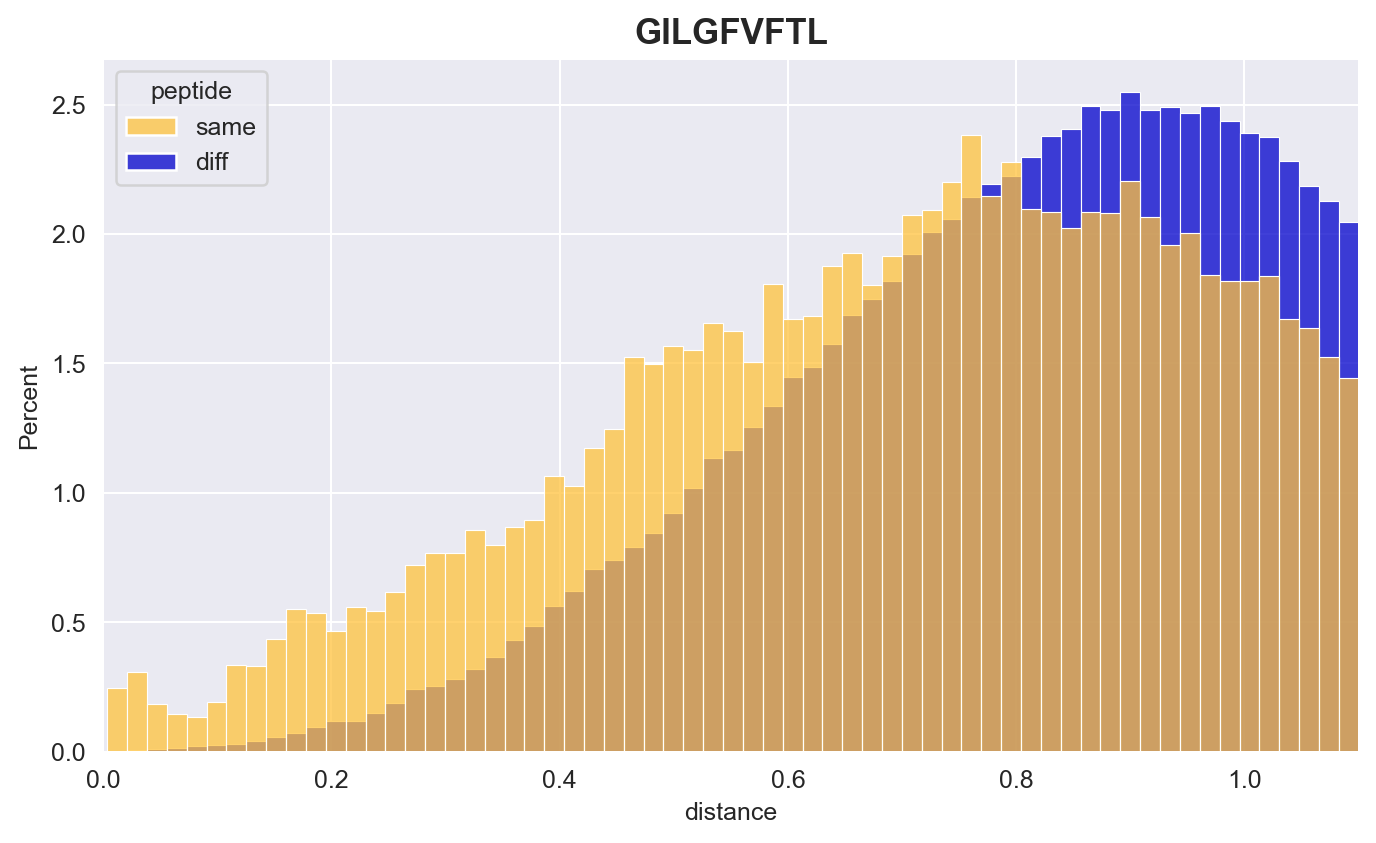

In [66]:
from src.sim_utils import do_histplot_distribution
dist_giltcrs = make_dist_matrix(pd.concat([gil_tcrs, not_tcrs]), 
                 label_col='peptide', seq_cols = seq_cols,
                 cols=['binder', 'seq_id', 'peptide'])
dist_giltcrs['label'] = dist_giltcrs['peptide'].apply(lambda x: int(x=="GILGFVFTL"))
dist_giltcrs['original_peptide']=dist_giltcrs['peptide']
do_histplot_distribution(dist_giltcrs, peptide="GILGFVFTL", label_col='peptide')

In [69]:
def pipe_compare(df_a, df_b, peptide, 
                 seq_cols=['A1','A2','A3','B1','B2','B3','peptide','modality'],
                title=None, xlim=None):
    dm = make_dist_matrix(pd.concat([df_a, df_b]), label_col='peptide', seq_cols=seq_cols,
                          cols=['binder','seq_id','peptide','modality'])
    dm['original_peptide']=dm['peptide']
    do_histplot_distribution(dm, peptide=peptide, label_col='peptide', xlim=xlim, title=title)

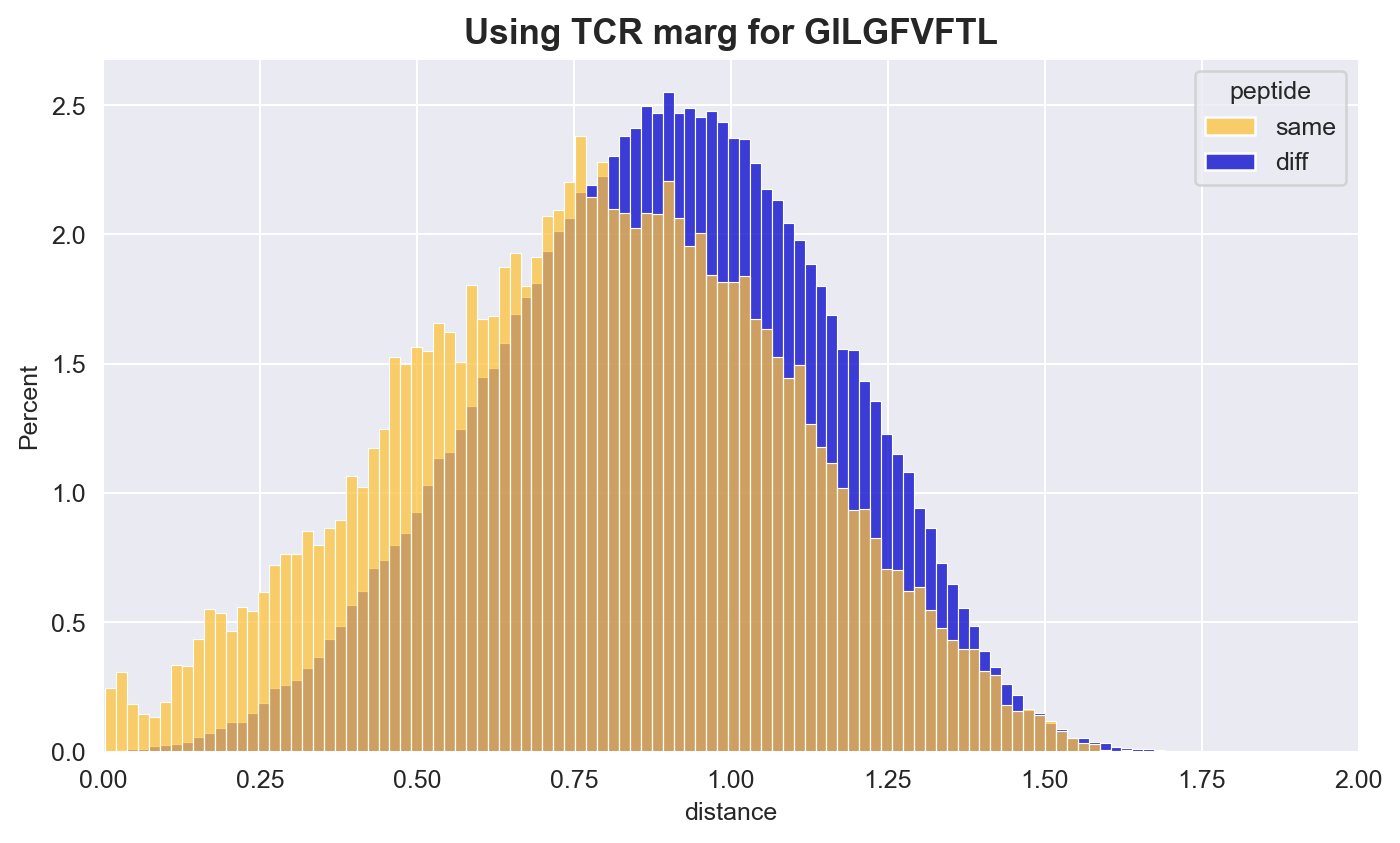

In [106]:
pipe_compare(gil_tcrs, not_tcrs, 'GILGFVFTL', title='Using TCR marg for GILGFVFTL', xlim=[0, 2])

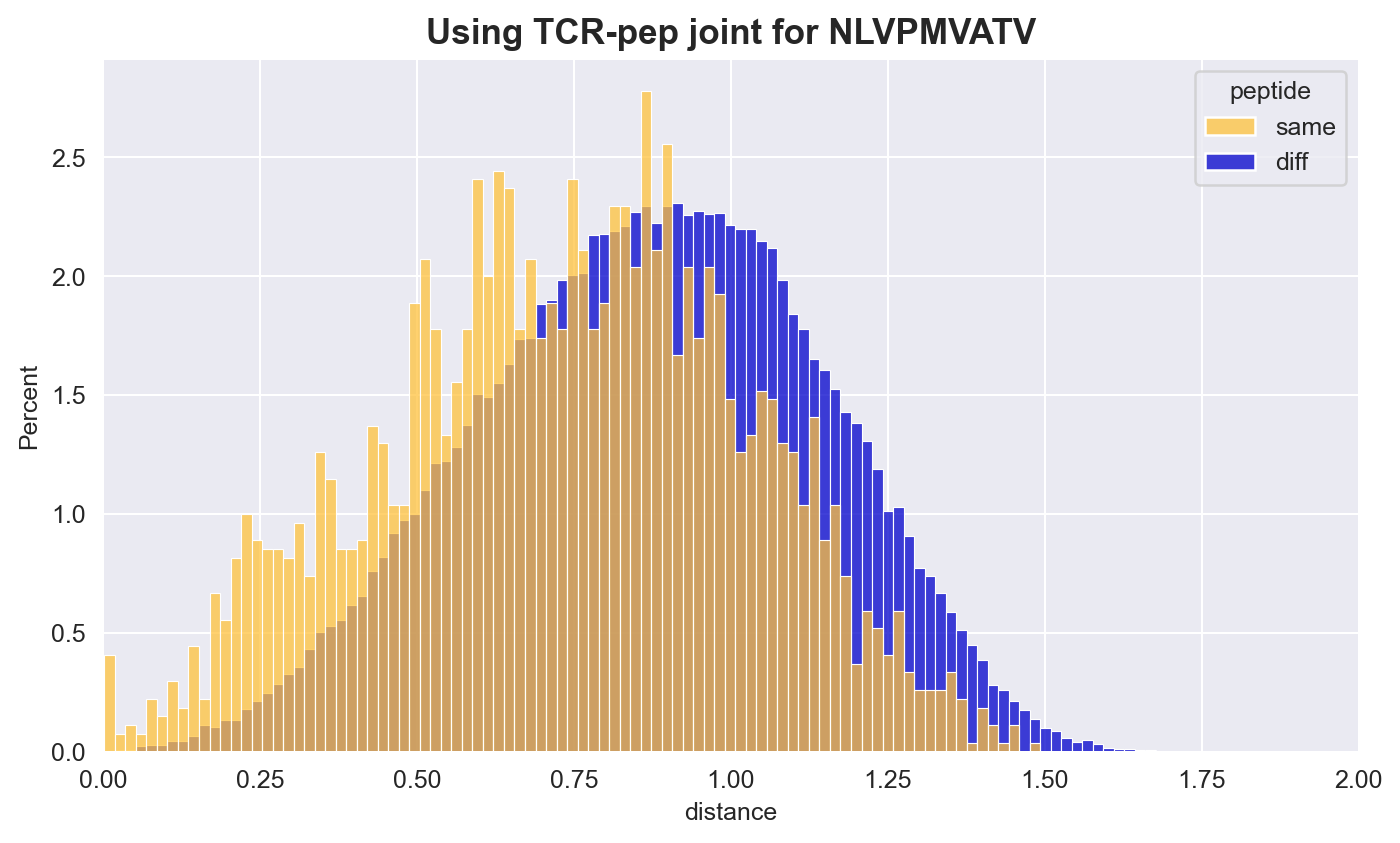

In [112]:
pipe_compare(valid_preds.query('peptide=="NLVPMVATV" and modality=="joint"'), 
             valid_preds.query('peptide!="NLVPMVATV" and modality=="joint"'),
             'NLVPMVATV', title='Using TCR-pep joint for NLVPMVATV', xlim=[0, 2])

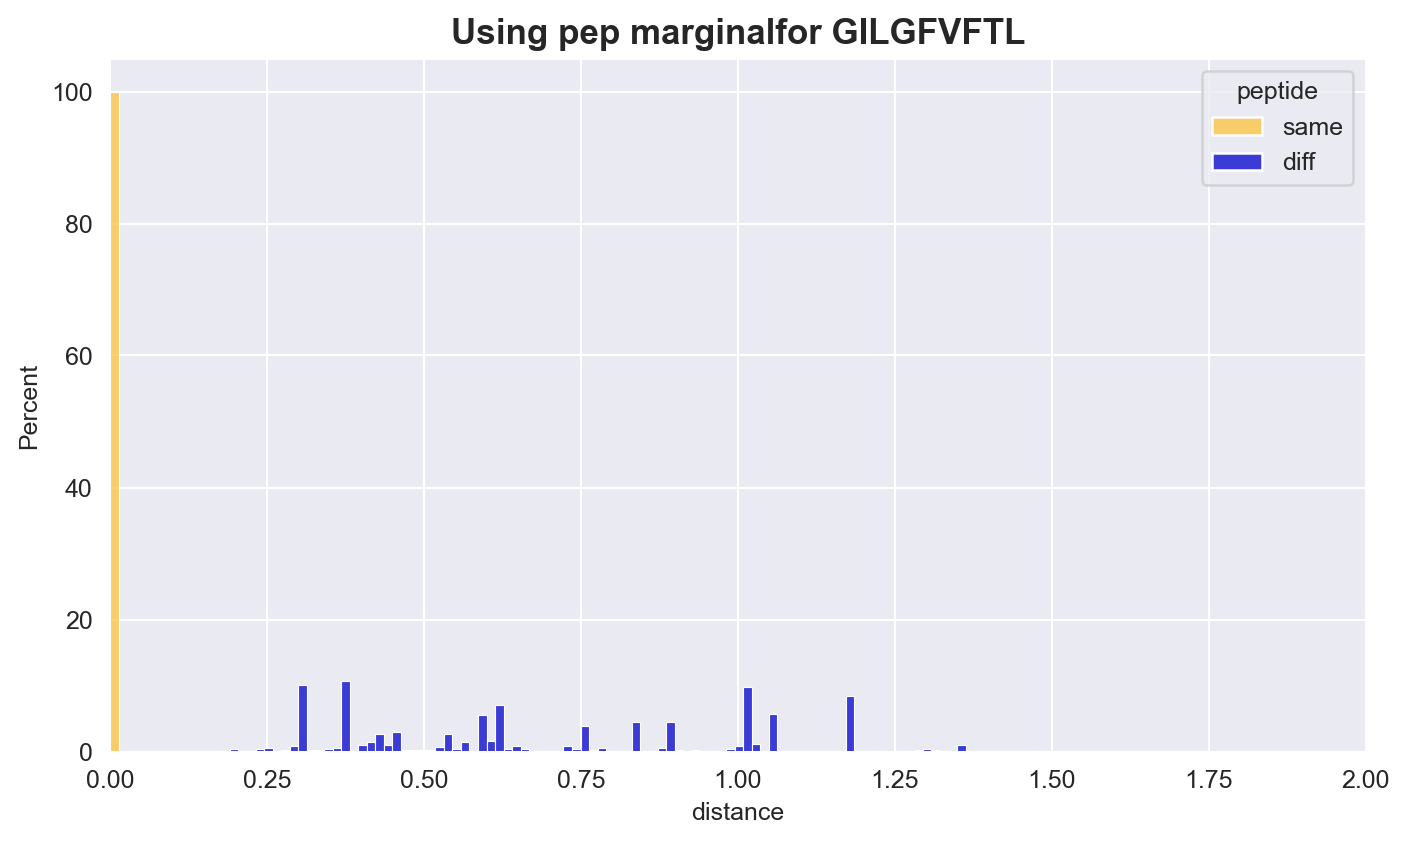

In [105]:
pipe_compare(gil_peps, not_peps, 'GILGFVFTL', title='Using pep marginalfor GILGFVFTL', xlim=[0, 2])

# nettcr

In [13]:
from sklearn.metrics import roc_auc_score
ntcr = pd.read_csv('../output/mmvaeclfs_computerome/nettcr_cv_pred_df.csv')
print(round(roc_auc_score(ntcr['binder'], ntcr['prediction']), 4))
print(round(roc_auc_score(ntcr['binder'], ntcr['prediction'], max_fpr=0.1), 4))

0.7924
0.6234
